# Mid-rapidity claculation

Simplest case where we consider z=0 and use that in the eikonal limit the gauge transformation is not needed

### Set Up

Set parameters and environment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 1          		
mu = g2mu / g**2

ns = 50      


nevents = 100

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.mid_rapidity as mr

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using Numba
Using SU(3)
Using double precision


### Simulation

We define the simulation routine

In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    nplus = maxt//DTS
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create and object to store the gauge links
    up = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create the object gauge link
    plink = mr.PlusLink(s)
    
    plink.init()
    
    # We simulate the event and store the U_+ when the temporal and spatial lattices match
    with tqdm(total=nplus) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # When the time and space lattices match we store the fields
            if t%DTS == 0:
                
                xplus = t//DTS
                
                plink.compute_plus_link(xplus)
                
                up[t//DTS] = plink.up.copy()
                
                pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We write the transformed fields in a dictionary
    output["up"] = up
    
    return output

We run the simulation

In [4]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    print('Event %i' % n)
    output = simulate()
    
    up = output['up']
    
    np.save(os.path.join('simulations', 'mid_rapidity', 'result_%i.npy' %n), up)

Event 0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


### Visualizing the results

We extract the color components

In [5]:
up_r = up.reshape(nplus, N, N, su.GROUP_ELEMENTS)
up_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_r)

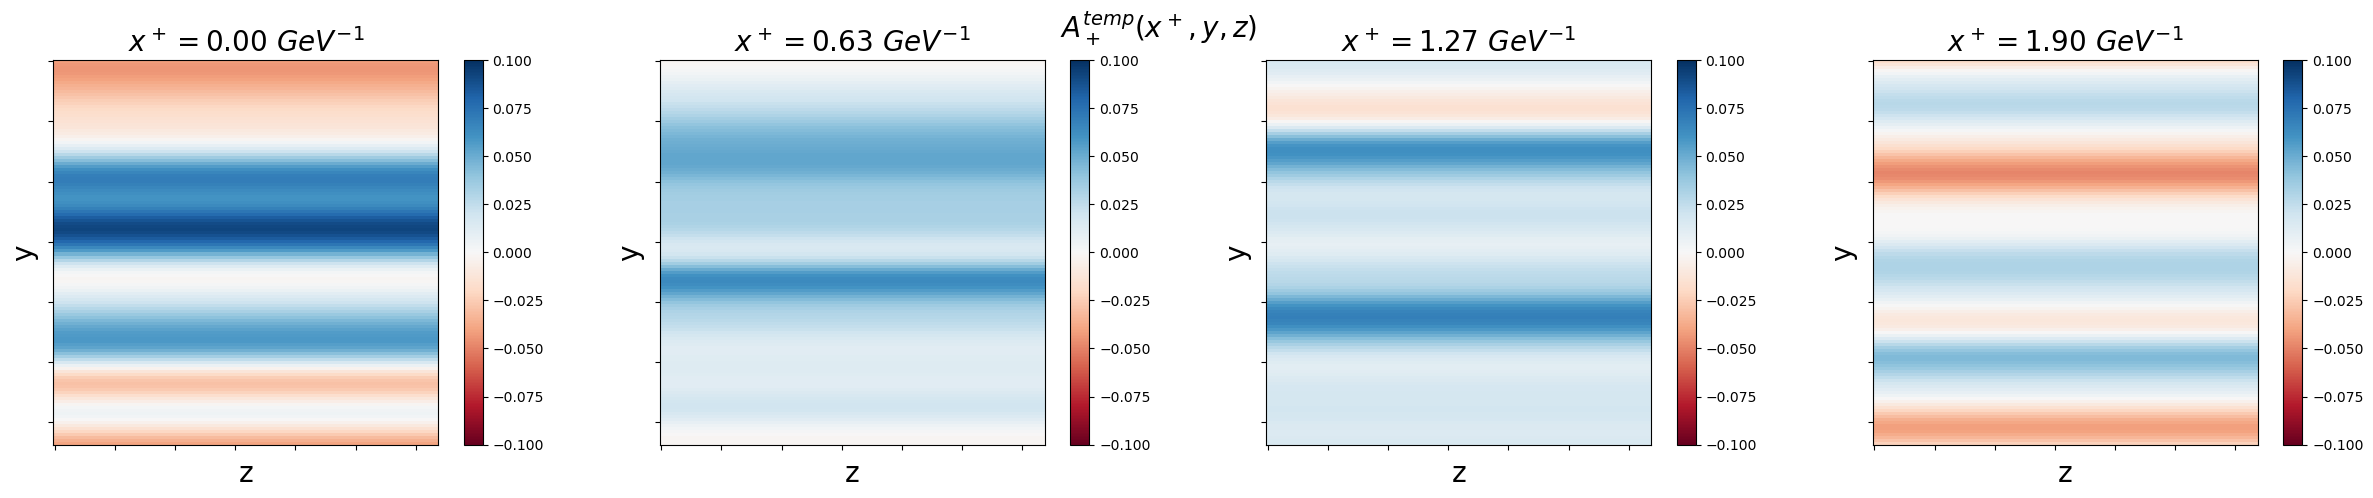

In [6]:
# We plot the temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//8, figsize=(30,5))
fig.suptitle(r'$A_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//8): 
    xplus = 8*t
    
    plot1 = axs[t].imshow(up_comp[xplus, :, :, 0].real, cmap='RdBu', vmin=-0.1, vmax=0.1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    axs[t].set_title(r'$x^+ = %.2f\ GeV^{-1}$' %(2*a*xplus/hbarc), fontsize=20)
    
# plt.savefig('zoom arround z=0')

## Light cone gauge calculation

Let us transform the fields to the LC gauge to see if the results are modified

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 1          		
mu = g2mu / g**2

ns = 50      


nevents = 1

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.mid_rapidity_lc as mr

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA
Using SU(3)
Using double precision


In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    nplus = maxt//DTS
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create the objects to store the fields at every time step
    ux_sim = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create and object to store the gauge links
    up = np.zeros((nplus-1, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create the object gauge link
    plink = mr.PlusLink(s)
    
    plink.init()
    
    # We simulate the event and store the Glasma fields at every time step
    with tqdm(total=nplus) as pbar:
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # When the time and space lattices match we store the fields
            if t%DTS == 0:
                
                xplus == t//DTS
                
                u1 = s.u1.copy()
                up[t//DTS] = u1[:, 0, :]
                
                plink.compute_plus_link(xplus, ux_sim)
            
                
        
                pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear() 
    
    # We write the transformed fields in a dictionary
    output["up"] = up
    
    return output

In [4]:
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    print('Event %i' % n)
    output = simulate()
    
    up = output['up']
    
    # np.save(os.path.join('simulations', 'mid_rapidity', 'result_%i.npy' %n), up)

Event 0


  0%|          | 0/32 [00:01<?, ?it/s]


NameError: name 'xplus' is not defined